# Test for decumulate IFS data

IFS fluxes are cumulated over monthly basis. This creates multiple issues in analysis.
We define a couple of funtions to check if a variale from IFS is a cumulative flux, and then another one to apply the derivative. 
So far it works, but it is too slow. Probably we need to remove the deep-copy and the loop over the different month.
It could be quite easy to generalize to different cumulation time. 

In [266]:
from aqua import Reader, catalogue

#filein='/work/bb1153/b382076/IFS-lowres/tco2559-ng5-r100-day/tsr_tco2559-ng5.nc'
#xfield = xr.open_mfdataset(filein)
#xfield

import copy
import xarray as xr
import numpy as np

def check_cumulate(xfield):

    """To check if a field need is cumulated. Arbitrary check"""

    # randomly pick a few timesteps from a gridpoint
    diff = xfield[2:20,10].diff(dim='time').values
    return (diff >= 0).all()

# so far this works, but it is very slow
# evident problems are the loop and the deepcopy, it might be possible to simplify
def decumulate(xfield, cumulation_time = 3600):
    """
    Test function to remove cumulative effect on IFS fluxes
    """

    # fluxes are reset every month
    loops = np.unique(xfield.time.dt.strftime("%Y-%m"))

    # copy seems required if we re-run the same call of the function
    clean = copy.deepcopy(xfield)
    
    for yyyymm in loops:
        # select the data from the month
        month = xfield.sel(time = (xfield.time.dt.strftime("%Y-%m")==yyyymm))
        
        # prepend an empty xarray
        zeros = xr.zeros_like(month.isel(time=0))
        zeros = zeros.assign_coords(time=zeros['time'] - np.timedelta64(24,'h'))

        # we might need to reorder the dimensions
        month = xr.concat([zeros, month], dim = 'time').transpose('time', ...)

        # perform the derivative and replace
        deltas = month.diff(dim='time') / cumulation_time

        # replacement in this way is quite heavy
        clean[dict(time=xfield.time.isin(deltas.time))] = deltas

    return clean

We load the catalog, ask for daily mean and regrid to r100. This is quite intensive already

In [267]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", freq='day', regrid='r100')
data = reader.retrieve(fix=False)

We check if we need to cumulate. We activate the decumulation, which takes 100seconds which is A LOT. However, it works

In [268]:
if check_cumulate(data['tsr']): 
    clean = decumulate(data['tsr'])
clean

<xarray.DataArray 'tsr' (time: 8329, value: 26306560)>
dask.array<setitem, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/16)
    paramId:                    178
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     toa_net_upward_shortwave_flux
    cfVarName:                  tsr
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

Then we apply average and regridding. Keep in mind that we need to decumlate before averaging, otherwise we can't do anything.

In [271]:
avg = reader.average(clean)
avg

<xarray.DataArray 'tsr' (time: 348, value: 26306560)>
dask.array<stack, shape=(348, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/16)
    paramId:                    178
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     toa_net_upward_shortwave_flux
    cfVarName:                  tsr
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [273]:
reg = reader.regrid(avg)
reg

<xarray.DataArray 'tsr' (time: 348, lat: 180, lon: 360)>
dask.array<reshape, shape=(348, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2021-01-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    178
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfVarName:                  tsr
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1

We finally decide to plot a single daily frame. The operation is slow, as expected, but it seems everything is correct.

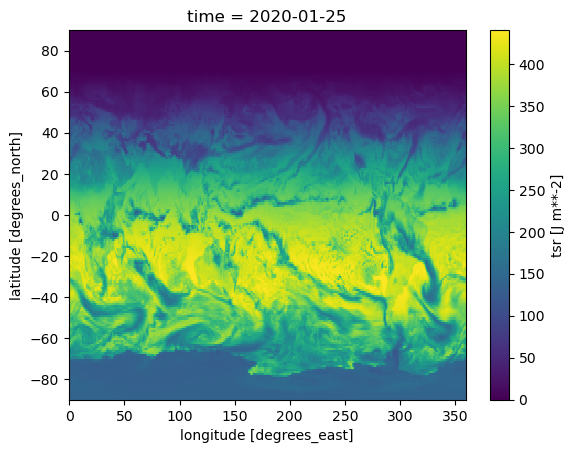

In [274]:
reg[5,:,:].plot()